<a href="https://colab.research.google.com/github/Raanank10/Instagram-s-influencers/blob/raanan_Instagram_Influencers_V2/Instagram_Influencers_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instagram_influencers**

# Global Parameters

In [127]:
path_part0 = 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/ai_posts_analysis_data.xlsx'
fname = 'ai_posts_analysis_data.xlsx'

path_part1= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part1.csv'
path_part2= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part2.csv'

train_size = 0.75
rand_state = 345
sigma = 3
Min_followers = 500

# Bining
bin_labels=['Low','Medium','High', 'Very High','Extreme']

In [128]:
# Run the code to install DataPrep
!pip install dataprep

In [129]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno
import xgboost as xgb
import datetime

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report # elad 20210708
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder # elad 20210911

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

# EDA prep
from dataprep.eda import plot, plot_correlation, plot_missing, create_report


# Get the Data

Concate the 3 files

In [130]:
df_part0 = pd.read_csv(path_part0, index_col=0)
df_part1 = pd.read_csv(path_part1, index_col=0)
df_part2 = pd.read_csv(path_part2, index_col=0)
df = pd.concat([df_part0, df_part1, df_part2])
print(f'data len After concat all 3 parts = {len(df)}')

data len After concat all 3 parts = 40849


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40849 entries, 1918 to 37857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          40849 non-null  int64  
 1   USERNAME                        40849 non-null  object 
 2   FULLNAME                        39489 non-null  object 
 3   FOLLOWER                        40849 non-null  int64  
 4   POST ID                         40849 non-null  float64
 5   SHORTCODE                       40849 non-null  object 
 6   LIKES                           40849 non-null  int64  
 7   COMMENTS                        40849 non-null  int64  
 8   ENGAGEMENT                      40849 non-null  float64
 9   URL                             40849 non-null  object 
 10  ACCESSIBILITY CAPTION           33725 non-null  object 
 11  CAPTION                         34786 non-null  object 
 12  LOCATION                     

# Data processing

In [132]:
print(f'Number of Duplicate Rows = {len(df[df.index.duplicated()])}')
df = df[~df.index.duplicated()]

Number of Duplicate Rows = 4792


In [133]:
print(f'Number of row of influencers with less than \
{Min_followers} followers = {len(df[df.FOLLOWER < Min_followers])}')

print(f'Number of row of influencers with more than \
{Min_followers} followers = {len(df[df.FOLLOWER > Min_followers])}')

df = df[df.FOLLOWER >= Min_followers]


Number of row of influencers with less than 500 followers = 13934
Number of row of influencers with more than 500 followers = 22063


## Remove Unnecessary Columns

Remove unnecessary columns from Dataframe, should be done in X

In [134]:
df.drop(['POST ID','VIDEO URL','SHORTCODE','IMAGE URL','FULLNAME','USERID',\
         'URL','VIDEO VIEW COUNT','URL'], inplace=True, axis=1)

Remove column that all values are unique:

In [135]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

df_original is holding the original data without any changes but droping unused columns and duplicates  

In [136]:
df_original = df.copy()

In [137]:
df.columns = df.columns.str.replace(' ', '_')

In [138]:
df = df[df['ENGAGEMENT'].notna()]
df = df[df['LIKES'].notna()]
df = df[df['COMMENTS'].notna()]
print(f'After remove lines with no data on ENGAGEMENT, LIKES, COMMENTS = {len(df)}')

After remove lines with no data on ENGAGEMENT, LIKES, COMMENTS = 22123


# Feature Engineering

Create Log columns (likes, comments and engagement) for prediction 

In [139]:
df['log_ENGAGEMENT'] = np.log1p(df.ENGAGEMENT)
df['log_LIKES'] = np.log1p(df.LIKES)
df['log_COMMENTS'] = np.log1p(df.COMMENTS)

Process Image Labels Column to dummies columns

In [140]:
df.IMAGE_LABELS = df.IMAGE_LABELS.str.replace(' ', '')
df['IMAGE_LABELS'] = df['IMAGE_LABELS'].str.upper()
df_image_labels_dummies = df['IMAGE_LABELS'].str.get_dummies(sep=',')

In [141]:
df_image_labels_dummies_style = df_image_labels_dummies[['HUMAN','FOOTWEAR','FACE','FEMALE','SMILE','SWIMWEAR','FINGER',
                                                         'SLEEVE','EVENINGDRESS','HEAD','JEWELRY','WOMAN','TEXT','SKIN',
                                                         'APPAREL','HAT','PHOTO','FASHION','POSTER','UNDERWEAR']]

In [142]:
#df_with_dummies 
df = pd.concat([df, df_image_labels_dummies_style], axis=1)

Create Mean columns for likes, comments, engagement

In [143]:
mean_likes = df.groupby('USERNAME')['LIKES'].mean()
mean_comments = df.groupby('USERNAME')['COMMENTS'].mean()
mean_engagement = df.groupby('USERNAME')['ENGAGEMENT'].mean()

df = df.set_index(['USERNAME']) # make the same index here
df_original = df_original.set_index(['USERNAME']) # make the same index here

df['mean_likes'] = mean_likes
df_original['mean_likes'] = mean_likes

df['mean_comments'] = mean_comments
df_original['mean_comments'] = mean_comments

df = df.reset_index()
df_original = df_original.reset_index()

Create Date and Time Features from DATETIME unix time column

In [144]:
df['DATETIME'] = pd.to_datetime(df['TIME'],unit='s')
df['YEAR'] = pd.DatetimeIndex(df['DATETIME']).year
df['MONTH'] = pd.DatetimeIndex(df['DATETIME']).month
df['DAY'] = pd.DatetimeIndex(df['DATETIME']).day
df['DAYOFWEEK'] = pd.DatetimeIndex(df['DATETIME']).dayofweek
df['HOUR'] = pd.DatetimeIndex(df['DATETIME']).hour
df['MINUTE'] = pd.DatetimeIndex(df['DATETIME']).minute

In [145]:
X.drop(['USERNAME','TIME'], axis=1, inplace=True)

KeyError: ignored

In [ ]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [ ]:
df = df.rename_axis('LINE_NUM_INDEX')

Replace NaN with Null, this is prerequisite for Caption text analysis

In [ ]:
for col in df.columns:
    if len(df[df[col].isnull()]) > 0:
      df[col] = df[col].fillna('Null')
      print(col)

Feature Engineering Based on Caption text analysis

In [ ]:
df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]
df['NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("!"))
df['NUMBER_OF_QUESTION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("?"))
df['NUMBER_OF_HASH_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("#"))
df['NUMBER_OF_AT_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("@"))
df['NUMBER_OF_COMMA_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count(","))

Feature Engineering Based on Accessibility Caption text analysis

In [ ]:
df['NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN'] = [len(x.split()) for x in df['ACCESSIBILITY_CAPTION'].tolist()]
df['NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("!"))
df['NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("?"))
df['NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("#"))
df['NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("@"))
df['NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count(","))

Create Binning of Likes, Comments, Engagement

In [ ]:
map_dict_rank = {'Low':0.0 , 'Medium':1.0, 'High':2.0, 'Very High':3.0, 'Extreme':4.0}
map_dict_rank


In [ ]:
df['LIKES_RANK'] = pd.cut(x=df.log_LIKES,  bins=5, labels=bin_labels, ordered=True)
df['COMMENTS_RANK'] = pd.cut(x=df.log_COMMENTS,  bins=5, labels=bin_labels, ordered=True)
df['ENGAGEMENT_RANK'] = pd.cut(x=df.log_ENGAGEMENT,  bins=5, labels=bin_labels, ordered=True)

In [ ]:
df['LIKES_RANK_INT'] =  df['LIKES_RANK'].map(map_dict_rank).astype(int)
df['COMMENTS_RANK_INT'] =   df['COMMENTS_RANK'].map(map_dict_rank).astype(int)
df['ENGAGEMENT_RANK_INT'] =   df['ENGAGEMENT_RANK'].map(map_dict_rank).astype(int)

# Ordinal Encoder

In [ ]:
enc = OrdinalEncoder()

In [ ]:
for col in df.select_dtypes(include=['object']).dtypes.index:
  enc.fit(df[[col]])
  df[col + '_OBJECT_AS_INT'] = enc.transform(df[[col]])

In [ ]:
df.info()

# Spliting the Data

seperate the row data

In [ ]:
df_video = df[df['IS_VIDEO']==1]
df_image = df[df['IS_VIDEO'] == 0]
df_image_style = df_image[df_image['IMAGE_LABEL_INTEREST'] == 'style_fashion']

Separate X, y

In [ ]:
X = df_image_style.select_dtypes(include=['number'])
X.drop(['LIKES','COMMENTS','ENGAGEMENT','mean_likes','mean_comments',\
        'log_ENGAGEMENT','log_LIKES','log_COMMENTS'], axis=1, inplace=True)
X.drop(['LIKES_RANK_INT','COMMENTS_RANK_INT','ENGAGEMENT_RANK_INT'], axis=1, inplace=True)



In [ ]:
X.info()

In [ ]:
y1 = df_image_style['log_LIKES']
y2 = df_image_style['log_COMMENTS']
y3 = df_image_style['log_ENGAGEMENT']

Spilt Train and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)
                           

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels (y) Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels(y) Shape:', y_test.shape)

# XGBoost Likes and Comments Prediction

In [ ]:
XGB_reg_likes = xgb.XGBRegressor(
colsample_bytree= 1, max_depth= 2, n_estimators= 200
)

In [ ]:
# XGB_param_grid = {'colsample_bytree': [0.3, 0.7, 1.0, 1.2],
#     'n_estimators': [50,100,200],    'max_depth': [2,3,4]
# }
# XGB_reg_grid = xgb.XGBRegressor()
# grid_mse = GridSearchCV(param_grid=XGB_param_grid, estimator=XGB_reg_grid, 
#                         scoring='neg_mean_squared_error', cv=4, verbose=1)
# grid_mse.fit(X, y1)
# # Print the best parameters and lowest RMSE
# print("Best parameters found: ", grid_mse.best_params_)
# print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [ ]:
XGB_reg_likes.fit(X_train, y_train)

Evaluate the model

In [ ]:
score = XGB_reg_likes.score(X_train, y_train)  
print("Training score: ", score)

In [ ]:
scores = cross_val_score(XGB_reg_likes, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
y_test_pred= XGB_reg_likes.predict(X_test)
X_test_copy['y_test_pred'] = XGB_reg_likes.predict(X_test)

mse_XGB = mse(y_test, y_test_pred)

score_test = XGB_reg_likes.score(X_test,y_test_pred)  

print("test score: ", round(score_test,2))
print("MSE: %.2f" % mse_XGB)
print("RMSE: %.2f" % (mse_XGB**0.5))

print('MSE by likes after XGBoost model', round(10**mse_XGB,2))

In [ ]:
Series1 = 10**X_test_copy.y_test_pred
#Series2= X_test.mean_likes
#X_test_mean_likes
series3 = 10**y_test
series4 = series3 - Series1
series5 = Series1 - Series2 #X_test_mean_likes
# series6 = series3 / Series1 *100
# series7 = Series1 / X_test_mean_likes *100
res = round(pd.DataFrame({'like_predication': Series1,\ #'mean_likes': X_test_mean_likes \
                     'real_like': series3, \
                    'diff between like_predication and real_like': series4, \
                    'diff between like_predication and mean like': series5
                    # ,'% diff between like_predication and real_like': series6, \
                    # '% diff between like_predication and mean like': series7
                    }                   ))


In [ ]:
res.sample(10)

In [ ]:
# #boston = load_boston()
# sorted_idx = XGB_reg_likes.feature_importances_.argsort()
# #plt.barh
# df_feature_importances = pd.DataFrame(XGB_reg_likes.feature_importances_[sorted_idx])
# df_feature_importances_headers = pd.DataFrame(X.columns[sorted_idx])
# #plt.xlabel("Xgboost Feature Importance")

XGBoost feature Importances

In [146]:
sorted_idx = XGB_reg_likes.feature_importances_.argsort()
pd.DataFrame(XGB_reg_likes.feature_importances_[sorted_idx], 
             index=list(X.columns[sorted_idx]),
             columns=["Feature_Value"]).sort_values(by="Feature_Value",ascending=False)

,Feature_Value
FOLLOWER,0.192168
HUMAN,0.127165
NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION,0.094631
APPAREL,0.035881
FOOTWEAR,0.033617
SWIMWEAR,0.032990
MONTH,0.026346
CAPTION_INTEREST_OBJECT_AS_INT,0.022556
YEAR,0.021650
NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION,0.021248


# SHAP Understanding the model

In [149]:
!pip install shap
import shap
shap.initjs()

     |████████████████████████████████| 371 kB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509236 sha256=7a3861da5034babeaad9046833205875a93bea01d92c3ce6a129e389d3fb60e8
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


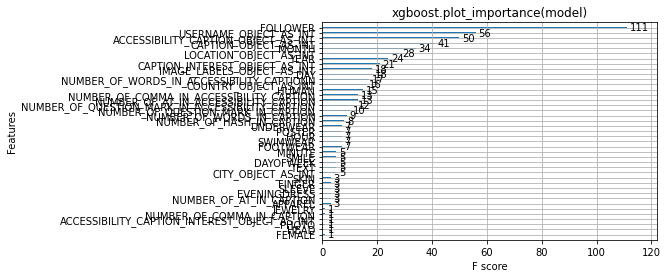

In [148]:
xgb.plot_importance(XGB_reg_likes)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [151]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(XGB_reg_likes)
shap_values = explainer(X)

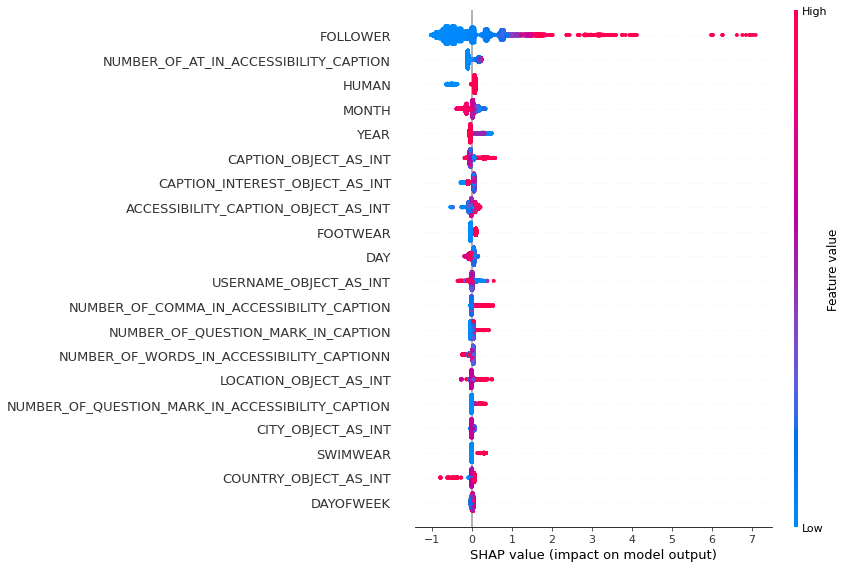

In [152]:
shap.summary_plot(shap_values, X)

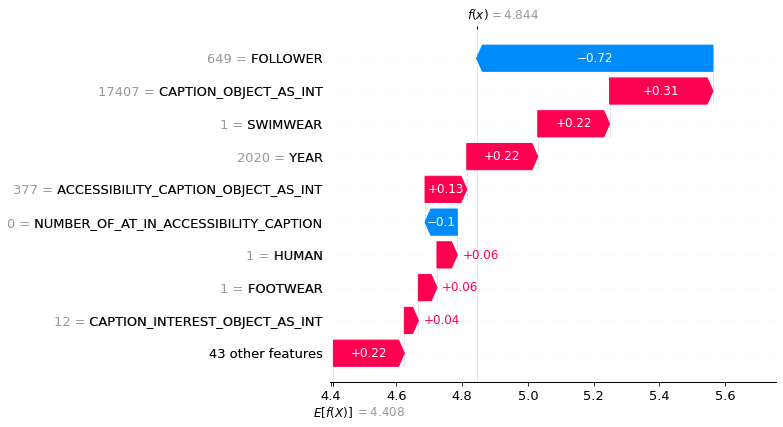

In [153]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[54])

In [155]:
#shap.dependence_plot("SWIMWEAR", shap_values, X)

ValueError: ignored

In [156]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

AssertionError: ignored

In [157]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [ ]:
# visualize all the training set predictions
shap.plots.force(shap_values)

# Appendix - Data Visualization

In [ ]:
df.info()

# EDA

EDA Only, this section is not require for Production code

In [ ]:
df.apply(lambda col: len(col.unique())).sort_values(ascending=False)

In [ ]:
# Descriptive statistics for each column
df.describe()

In [ ]:
plot_missing(df)

In [ ]:
df.isnull().sum()

In [ ]:
plot(df, "ENGAGEMENT")

In [ ]:
plot(df, "LIKES")

In [ ]:
plot(df, "COMMENTS")

In [ ]:
plot(df, "FOLLOWER")

In [ ]:
plot(df,'USERNAME')

In [ ]:
plot(df,'CAPTION')

In [ ]:
plot(df,'CAPTION_INTEREST')

In [ ]:
df.columns

In [ ]:
plot(df,'log_ENGAGEMENT')

In [ ]:
plot(df,'log_LIKES')

In [ ]:
plot(df,'log_COMMENTS')

In [ ]:
df.info()

mean likes and comments

In [ ]:
 df.groupby('USERNAME')['LIKES'].mean().sort_values(ascending=False).head(10)

In [ ]:
 df.groupby('USERNAME')['COMMENTS'].mean().sort_values(ascending=False).head(10)

In [ ]:
df.groupby('USERNAME')['ENGAGEMENT'].mean().sort_values(ascending=False).head(10)
#df.groupby('FULLNAME')['ENGAGEMENT'].mean().sort_values(ascending=False).head(10)

In [ ]:
IMAGE_LABELS = df.groupby('CAPTION_INTEREST').size().sort_values()
IMAGE_LABELS.plot.barh(figsize=(8, 15), fontsize=10, title='CAPTION_INTEREST')

## Sigma cleaning

In [ ]:
# # we lose the most viral posts and most unviral posts
# for col in df.columns:
#     if df[col].dtype == 'float64':
#         std = df[col].std()
#         ave = df[col].mean()
#         df = df.loc[df[col].between\
#                                (ave - (sigma * std), ave + (sigma * std))] 
#         print(f'Processing {col:10} --> {df.shape[0]:5} entities entries remain')

In [ ]:
df.describe()

How Many NaN values are ther in the datast?

In [ ]:
msno.matrix(df)

In [ ]:
msno.bar(df, figsize=(20, 8))

## Some Data Visualization (mostly on time)

In [ ]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [ ]:
df.columns

In [ ]:
per_DAYOFWEEK = df.groupby('DAYOFWEEK').agg(NUM_OF_LIKES=('LIKES','sum'),
                                            Average_OF_LIKES=('LIKES','mean'),
                                            median_OF_LIKES=('LIKES','median')
                                            )

per_DAYOFWEEK["NUM_OF_LIKES_IN_THOUSANDS"] = per_DAYOFWEEK['NUM_OF_LIKES']/1000
per_DAYOFWEEK.plot(y=["NUM_OF_LIKES_IN_THOUSANDS",
                      "Average_OF_LIKES","median_OF_LIKES"], kind="bar",figsize=(12,8))
per_DAYOFWEEK

In [ ]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [ ]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [ ]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["LIKES"], kind="bar",figsize=(12,8))

In [ ]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

In [ ]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["LIKES"], kind="bar",figsize=(12,8))

In [ ]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["LIKES"], kind="bar",figsize=(12,8))

In [ ]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

In [ ]:
df.columns

Remove column that all values are unique:

In [ ]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

In [ ]:
df.head()

In [ ]:
df.URL.head()
# SHORTCODE
# URL
# IMAGE_URL
# VIDEO_URL # Not working

## feature engeneering base on text in columns CAPTION ,ACCESSIBILITY_CAP

```
# This is formatted as code
```

TION:

new columns for featur engeneering for 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS':
*   Number of Hash # in 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS',
*   Number of AT @ in CAPTION
*   Number of question mark? in CAPTION
*   Number of , in CAPTION
*   Number of Words in CAPTION

7-Oct

In [ ]:
#count number of !
#df['exc'] = df['line'].map(lambda x: x.count("!"))

In [ ]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)

In [ ]:
#Number of Words in CAPTION:
#d['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df[df.index == 2728].CAPTION.tolist()]
#d['words'] = [len(x.split()) for x in d['CAPTION'].tolist()]
#df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]

Sampleing:

In [ ]:
num_of_samples = 5
list_of_sample_index = list((df.URL.sample(num_of_samples).index.values))
print('indesc sample are: ', list_of_sample_index)
print(df.loc[list_of_sample_index]['URL'])
df.loc[list_of_sample_index][['LIKES','CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS','CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST','IMAGE_LABEL_INTEREST'
,'FOLLOWER','LOCATION'
]]

## Remove unneccessary columns from Dataframe

In [ ]:
df.drop(['POST_ID','VIDEO_URL','SHORTCODE','IMAGE_URL','USERID','FULLNAME','USERNAME',
         'USERID','TIME',#'URL',
         'VIDEO_VIEW_COUNT'],inplace=True,axis=1)

After talking with Royi on 1-Oct: 

In [ ]:
df.info()

Convert columns type to characters :

In [ ]:
df['COMMENT_DISABLED'].value_counts()

In [ ]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [ ]:
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))

In [ ]:
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [ ]:
df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].value_counts()

In [ ]:
pd.unique(df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].values.ravel('K'))

In [ ]:
msno.matrix(df)

In [ ]:
df.columns

Raname the index

In [ ]:
df = df.rename_axis('LINE_NUM_INDEX')

Note by Eladk: we can fill location values by using a merdiction model base in the influancer and the time for the post. <BR> 
For Now, I'll just fill the columns with NULL

Replace all cases where VIDEO_VIEW_COUNT == Nan with 0. <BR> for double check i verified it with is_video column

Eladk note 8-Sep-2021: I still need to handle missing values in column:


*   FULLNAME
*   ACCESSIBILITY_CAPTION - specify full name, time, location, video or picture and tag
*   CAPTION - the text on this post (by the post uploader
*   LOCATION, CITY, COUNTRY - location
*   CAPTION_INTEREST -
*   ACCESSIBILITY_CAPTION_INTEREST


In [ ]:
msno.matrix(df)

In [ ]:
df.CAPTION.value_counts().sort_values(ascending=False)

selecting a subset of the data:

In [ ]:
df[['ACCESSIBILITY_CAPTION','CAPTION','LOCATION', 'CITY', 'COUNTRY'\
    ,'CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(5)

Increase the length to a column so that we'll see all the text in a cell

In [ ]:
pd.options.display.max_colwidth = 1000
df.ACCESSIBILITY_CAPTION.head(5)

Selecting 1 row by index (specific column only)

In [ ]:
#df[df.index == 1929][['URL','ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 
df[df.index == 1929][['ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 

In [ ]:
df.columns

In [ ]:
df[['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(20)

In [ ]:
#df[df.index == 1932][['URL','CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name, 
df[df.index == 1932][['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name,

there are 308 combination as CAPTION_INTEREST and ACCESSIBILITY_CAPTION_INTEREST

In [ ]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

there are 35 unique CAPTION_INTEREST


In [ ]:
df.groupby(['CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

there are 26 unique ACCESSIBILITY_CAPTION_INTEREST


In [ ]:
df.groupby(['ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(30)

Eladk 1-Oct , creat new column the state if CAPTION_INTEREST == ACCESSIBILITY_CAPTION_INTEREST

In [ ]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

##  Handle NaN valus 

For Now (Eladk 2021-Sep-11) I'll fill every NaN with Null

In [ ]:
msno.matrix(df)

In [ ]:
#https://datatofish.com/rows-with-nan-pandas-dataframe/
#len(df[df['FULLNAME'].isna()]) # 126 #849
#df[df['FULLNAME'].isnull()]
#df[df.isna().any(axis=1)] # len = 4020
#df[df.isnull().any(axis=1)]

In [ ]:
for col in df.columns:
    if len(df[df[col].isnull()]) > 0:
      df[col] = df[col].fillna('Null')
      print(col)

In [ ]:
msno.matrix(df)

## creating new columns for featur engeneering base on the columns of CAPTION ,ACCESSIBILITY_CAPTION, IMAGE_LABELS :

new columns for featur engeneering for 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS':
*   Number of Hash # in 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS',
*   Number of AT @ in CAPTION
*   Number of question mark? in CAPTION
*   Number of , in CAPTION
*   Number of Words in CAPTION

the source for the code is from: https://towardsdatascience.com/9-functions-that-make-natural-language-pre-processing-a-piece-of-cake-8b885c151955 <BR>
7-Oct

In [ ]:
#count number of !
#df['exc'] = df['line'].map(lambda x: x.count("!"))

In [ ]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)
d

In [ ]:
'Number_of_expamation_mark_in_CAPTION'.upper()

In [ ]:
#Count the most repeated words example:
#pd.DataFrame(Counter('elad elad katz elad katz'.split()).most_common(2000), columns=['word', 'frequency'])

In [ ]:
#Count the most repeated words
#from collections import Counter
#pd.DataFrame(Counter(d[['CAPTION']].split()).most_common(200), columns=['word', 'frequency'])

In [ ]:
'exclamation'.upper()

Caption Feature Engineering

New columns for feature engineering cased on Caption:

New columns for feature engineering cased on ACCESSIBILITY_CAPTION:

In [ ]:
#10. Count emojis
# import emoji
# emojis_df=[]
# for string in df['line']:
#     my_str = str(string)
#     for each in my_str:
#         if each in emoji.UNICODE_EMOJI:
#             emojis_df.append(each)
# freq = dict(Counter(i for sub in emojis_df for i in set(sub))) 
# sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)

View specific line

In [ ]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)

Sampling the row data df:

In [ ]:
num_of_samples = 5
list_of_sample_index = list((df.URL.sample(num_of_samples).index.values))
print('indesc sample are: ', list_of_sample_index)
print(df.loc[list_of_sample_index]['URL'])
df.loc[list_of_sample_index][['LIKES','CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS','CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST','IMAGE_LABEL_INTEREST'
,'FOLLOWER','LOCATION'
,'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION','NUMBER_OF_QUESTION_MARK_IN_CAPTION','NUMBER_OF_HASH_IN_CAPTION','NUMBER_OF_AT_IN_CAPTION','NUMBER_OF_COMMA_IN_CAPTION' # <- new added columns
]]

## ## Remove unneccessary columns from Dataframe 2, URL

In [ ]:
df.drop(['URL'],inplace=True,axis=1)

In [ ]:
df.IMAGE_LABEL_INTEREST.unique()

In [ ]:
df.IMAGE_LABEL_INTEREST.value_counts()

In [ ]:
IMAGE_LABEL_INTEREST = df.groupby(['IMAGE_LABEL_INTEREST']).head(10)
print(IMAGE_LABEL_INTEREST)

## Create bins (buckets) of Likes, Comment Engagement so we can use a classification model

In [ ]:
sns.histplot(x = df.LIKES,bins=50)

In [ ]:
#bins_LIKES=[min(df.LIKES)-1,15,40,200,400,max(df.LIKES)+1]
pd.cut(x=df.LIKES, bins=5).value_counts()
#pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
#       ordered=True).value_counts()

In [ ]:
pd.cut(x=df.log_LIKES, bins=5).value_counts()

In [ ]:
sns.histplot(x = df.COMMENTS,bins=50)

In [ ]:
len(df.COMMENTS) #3921

In [ ]:
bins_COMMENTS=[min(df.COMMENTS)-1,1,5,40,60,max(df.COMMENTS)]
#pd.cut(x=df.COMMENTS, bins=5).value_counts()
pd.cut(x=df.COMMENTS, bins=bins_COMMENTS#, labels=labels 
        ,ordered=True).value_counts()

In [ ]:
sns.histplot(x = df.ENGAGEMENT,bins=50)

In [ ]:
bins_ENGAGEMENT=[min(df.ENGAGEMENT)-1,1.5,3.5,10,15,max(df.ENGAGEMENT)]
pd.cut(x=df.ENGAGEMENT, bins=5, labels=bin_labels, ordered=True).value_counts()
pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True).value_counts()

In [ ]:
df['ENGAGEMENT_RANK']

Convert Rank to Code using Dictionary 

In [ ]:
df.columns

In [ ]:
df.LIKES_RANK.unique()

In [ ]:
df['COMMENTS_RANK']

In [ ]:
map_dict_rank = {'Low':0.0 , 'Medium':1.0, 'High':2.0, 'Very High':3.0, 'Extreme':4.0}
map_dict_rank

In [ ]:
df[['LIKES_RANK','LIKES_RANK_INT']].value_counts().sort_index()

In [ ]:
df[['COMMENTS_RANK','COMMENTS_RANK_INT']].value_counts().sort_index()

In [ ]:
df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_INT']].value_counts().sort_index()

In [ ]:
p = sns.violinplot(x='ENGAGEMENT_RANK', y='ENGAGEMENT', 
                    #order=cut_order, 
                    data=df)

## Eladk 28-Sep-2021, more bucketing



1.  VIDEO_VIEW_COUNT          41.148879
2.  FOLLOWER                  35.852012
3.  USERNAME_OBJECT_AS_INT    17.961764
4.  CAPTION_OBJECT_AS_INT      3.558228
5.  HOUR                       1.201713
6.  MINUTE                     0.277403



In [ ]:
df.FOLLOWER.value_counts().sort_values(ascending=False).plot.bar()
#.reindex()

## Replacing Charecters  with Number uning OrdinalEncoder

In [ ]:
# list of char / object columns

In [ ]:
df.dtypes

In [ ]:
df.select_dtypes(include=['object']).dtypes

In [ ]:
df.select_dtypes(include=['object']).dtypes.index

In [ ]:
df.info()

In [ ]:
df.info()

In [ ]:
df.head(2)

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Relationship Between The Features of The instagram Data")
sns.heatmap(df.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [ ]:
# %%time 
# df = df.select_dtypes(include=np.number)
# sns.pairplot(df ,height=1.8) # takes about 5 min.

## More EDA

In [ ]:
df.head(2)

## Feature Engneering

## Image captioning

In [ ]:
pd.concat([df.IMAGE_LABELS.str.split(', ', expand=True)], axis=1)####2


In [ ]:
dfcleancsv = pd.concat([df,pd.concat([df.IMAGE_LABELS.str.split(', ', expand=True)], axis=1)])
dfcleancsv.info()###2


Eladk 2021-Sep-17, we need to:


*   convert y colum to 5 classes so we can have a classification problem and not a regresion model
*   check if the data is inbalance (so we need to use stratify)



# Split the Data for image, video and style post

In [ ]:
df.info()

In [ ]:
df_image = df[df['IS_VIDEO'] == 0]
df_image.info()

In [ ]:
df_video = df[df['IS_VIDEO']=='yes']
df_image = df[df['IS_VIDEO'] == 0]
df_image_style = df_image[df_image['IMAGE_LABEL_INTEREST'] == 'style_fashion']

In [ ]:
df_image_style = df_image[df_image['IMAGE_LABEL_INTEREST'] == 'style_fashion']
df_image_style.info()

In [ ]:
df_video = df[df['IS_VIDEO']=='yes']
df_video.info()

# Split the Data for modules

select only int and float column types to X 
seletc LIKES, COMMENTS, ENGAGEMENT as y

In [ ]:
df_image.columns

In [ ]:
df_video.columns

X is taken from Image interst = style only

In [ ]:
X = df_image_style.select_dtypes(include=['number'])
X.drop(['LIKES','COMMENTS','ENGAGEMENT','log_ENGAGEMENT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
X.drop(['LIKES_RANK_INT','COMMENTS_RANK_INT','ENGAGEMENT_RANK_INT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
X.drop(['log_LIKES','log_COMMENTS'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
df_video.columns

In [ ]:
y = df_image_style['ENGAGEMENT']
y1 = df_image_style['log_LIKES']
y2 = df_image_style['COMMENTS']
y3 = df_image_style['log_ENGAGEMENT']
y_ENGAGEMENT_RANK_INT = df_image_style['ENGAGEMENT_RANK_INT']
y_LIKES_RANK_INT = df_image_style['LIKES_RANK_INT']
y_COMMENTS_RANK_INT = df_image_style['COMMENTS_RANK_INT']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels (y) Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels(y) Shape:', y_test.shape)

# Mechine Learning  Model for df_image

## Appling First1 Model - KNN model

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = (mse(y_test,pred))**0.5 #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [ ]:
min_mse_k = min(rmse_val)
min_index = rmse_val.index(min_mse_k)
print(min_index, min_mse_k)

In [ ]:
neighbor = min_index
knn_model_1 = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train, y_train)

In [ ]:
y_train_pred = knn_model_1.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_train[-150:]))), y=y_train[-150:],
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_train_pred[-150:]))), y=y_train_pred[-150:],
                         mode='lines',
                         name='True value'))

fig.show()

## Validating the Model 

In [ ]:
MSE = mse(y_train, y_train_pred)
MSE

In [ ]:
like_mse = 10**MSE
like_mse

like_mse = 11.330576957305144

In [ ]:
y_test_pred = knn_model_1.predict(X_test)
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
MSE_KNN = mse(y_test, y_test_pred)
print('MSE by likes after knn model', round(10**MSE_KNN,2))

print('r2_score: ', round(r2_score(y_test, y_test_pred)*100, 2))

MSE by likes 16.99 <BR>

r2_score:  39.33

## Scaled MaxAbsScaler model

In [ ]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors=10).fit(X_train_scaled, y_train)

In [ ]:
y_train_pred_knn_2 = knn_model_2.predict(X_train_scaled)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred_knn_2)
ax.plot(y_train, y_train, 'r')

In [ ]:
MSE_tr = mse(y_train, y_train_pred_knn_2)
MSE_tr

MSE_tr = 1.5217511500656686

In [ ]:
X_test_scaled = my_scaler.transform(X_test)
y_test_pred_scaled = knn_model_2.predict(X_test_scaled)

ax = sns.scatterplot(x=y_test, y=y_test_pred_scaled)
ax.plot(y_test, y_test, 'r')

In [ ]:
MSE_maxAbsScalar = mse(y_test, y_test_pred_scaled)
MSE_maxAbsScalar

In [ ]:
MSE_KNN_scaled = mse(y_test, y_test_pred_scaled)
print('MSE by likes after knn model', round(10**MSE_KNN_scaled,2))

print('r2_score: ', round(r2_score(y_test, y_test_pred_scaled)*100, 2))

MSE by likes 67.16 <BR>

r2_score:  9.9

MSE_maxAbsScalar = 

## Appling 2nd Model - Decision Tree with bins

In [ ]:
# model_2_dt = DecisionTreeClassifier(
#     min_samples_leaf=3
#     ,max_depth=5
#     )

In [ ]:
model_2_dt_pred_like = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [ ]:
model_2_dt_pred_comments = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [ ]:
X.columns

In [ ]:
# model_2_dt.fit(X, 
#               y_ENGAGEMENT_RANK_INT)

In [ ]:
model_2_dt_pred_like.fit(X, 
              y_LIKES_RANK_INT)

In [ ]:
model_2_dt_pred_comments.fit(X, 
              y_COMMENTS_RANK_INT)

In [ ]:
class_list = [str(x) for x in model_2_dt_pred_comments.classes_]
class_list

In [ ]:
dot_data = StringIO()  
export_graphviz(model_2_dt_pred_like, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt_pred_like.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

In [ ]:
dot_data = StringIO()  
export_graphviz(model_2_dt_pred_comments, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt_pred_comments.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

View Features Emportance:

In [ ]:
pd.Series(model_2_dt_pred_like.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

In [ ]:
pd.Series(model_2_dt_pred_comments.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

Eladk 2021-Sep-24 comment in first model:

*   Why Time is So meaning full?
*   What ACCESSIBILITY_CAPTION have corolation with ranking?
*   I Need to understand why folloer is very meaningfull
*   I Need to understand why USERNAME,userid is very meaningfull

In [ ]:
df.head(3)

In [ ]:
model_2_dt_pred_like.predict(X)

In [ ]:
# df['COMMENTS_RANK_INT_pred'] = model_2_dt_pred_comments.predict(X)
# df.head(1)

In [ ]:
s = pd.Series(model_2_dt_pred_like.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

In [ ]:
s = pd.Series(model_2_dt_pred_comments.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))
# map_dict_ENGAGEMENT

In [ ]:
#df['ENGAGEMENT_RANK_pred'] = df['ENGAGEMENT_RANK_INT_pred'].map(map_dict_ENGAGEMENT)

Evanuating the Model:

In [ ]:
#type(df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_pred']].value_counts())

In [ ]:
# df[['LIKES_RANK_INT','LIKES_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
# df[['COMMENTS_RANK_INT','COMMENTS_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
cm = confusion_matrix(y_true=df_image_style.LIKES_RANK_INT,
                      y_pred=model_2_dt_pred_like.predict(X))
pd.DataFrame(cm,
             index=model_2_dt_pred_like.classes_,
             columns=model_2_dt_pred_like.classes_)

In [ ]:
# cm = confusion_matrix(y_true=df.COMMENTS_RANK_INT,
#                       y_pred=df.COMMENTS_RANK_INT_pred)
# pd.DataFrame(cm,
#              index=model_2_dt.classes_,
#              columns=model_2_dt.classes_)

In [ ]:
print(classification_report(y_true=df_image_style.LIKES_RANK_INT,
                      y_pred=model_2_dt_pred_like.predict(X)))

In [ ]:
# print(classification_report(y_true=df.COMMENTS_RANK_INT,
#                       y_pred=df.COMMENTS_RANK_INT_pred))

In [ ]:
accuracy_score(y_true=df_image_style.LIKES_RANK_INT,
                      y_pred=model_2_dt_pred_like.predict(X))

accuracy_score = 0.7713802963348063

In [ ]:
# accuracy_score(y_true=df.COMMENTS_RANK_INT, y_pred=df.COMMENTS_RANK_INT_pred)

In [ ]:
# s = pd.Series(model_2_dt_pred_comments.feature_importances_*100,
#           index=X.columns).sort_values(ascending=False)

# s[s.gt(0)]

In [ ]:
# p = sns.violinplot(x='ENGAGEMENT_RANK', y='HOUR', 
#                     #order=cut_order, 
#                     data=df)

In [ ]:
# for index, val in pd.Series(model_2_dt.feature_importances_*100,index=X.columns).iteritems():
#   if val > 0:
#     plt.figure()
#     p = sns.violinplot(x='ENGAGEMENT_RANK', y=index, 
#                     #order=cut_order, 
#                     data=df)
    

## Scoring 

## Appling 3nd Model - Random Forest regression

In [ ]:
# # Instantiate model with 1000 decision trees
# rf = RandomForestRegressor(n_estimators = 1000, random_state = rand_state)
# # Train the model on training data
# rf.fit(X_train, y_train);

In [ ]:
# this parameters are best param acording to grid search for this model
rf = RandomForestRegressor(
bootstrap= True,
max_depth= 35,
max_features= 3,
min_samples_leaf= 3,
min_samples_split= 8,
n_estimators= 200)
# Train the model on training data
rf.fit(X_train, y_train);

Best Params according to grid search <BR>

{'bootstrap': True,
 'max_depth': 35,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [ ]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'log_of_Likes.')
print('Mean Absolute Error:', round(10**round(np.mean(errors), 2),2), 'likes.')

Mean Absolute Error: 0.51 log_of_Likes.
<BR>
Mean Absolute Error: 3.24 likes.

In [ ]:
ax = sns.scatterplot(x=y_test, y=rf_predictions)
ax.plot(y_train, y_train, 'r')

In [ ]:
x = np.linspace(0, len(y_test), len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x, y_test, label='y_test')
plt.plot(x, rf_predictions, label='y_prep')
plt.xlabel('index')
plt.ylabel('log_engament')
plt.legend()
plt.show()

In [ ]:
rf_y_train_pred = rf.predict(X_train)
MSE = mse(y_train, rf_y_train_pred)
MSE

MSR_rf =0.030273338737538496


In [ ]:
rf_y_test_pred = rf.predict(X_test)
MSE_rf = mse(y_test, rf_y_test_pred)
MSE_rf # = 0.20969612433881218

print('MSE by likes after Random forest model', round(10**MSE_rf,2))


MSR_rf = 3.09 Likes

Looks like we have a major overfitting hear...

In [ ]:
pd.Series(rf.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 35, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

### Random Forest Regression Grid search

In [ ]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_
# {'bootstrap': True,
#  'max_depth': 80,
#  'max_features': 3,
#  'min_samples_leaf': 5,
#  'min_samples_split': 12,
#  'n_estimators': 100}
# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, X_test, y_test)
# #Model Performance
# #Average Error: 3.6561 degrees.
# #Accuracy = 93.83%.
# #print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
# #Improvement of 0.50%.

In [ ]:
#grid_search.best_params_

{'bootstrap': True,
 'max_depth': 35,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

Avaluate Random Forest Regression model

## Appling 4nd Model - Random Forest Classification 

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_LIKES_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
# X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_COMMENTS_RANK_INT, train_size = train_size\
#                            , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
# X_train_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)
# X_test_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)

In [ ]:
X_train_4.columns

In [ ]:
model_rf_4 = RandomForestClassifier()

model_rf_4.fit(X_train_4,y_train_4) # X_test_4 is Engagment_rank
preds= model_rf_4.predict_proba(X_train_4)[:,1]

#roc_auc_score(y_test_4,preds)

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))

In [ ]:
pd.Series(model_rf_4.feature_importances_*100, index=X_train_4.columns).sort_values(ascending=False).round()#.plot.barh(figsize=(14,12))

In [ ]:
from sklearn import tree

In [ ]:
import six

In [ ]:
_ = tree.plot_tree(model_rf_4.estimators_[0], feature_names=X_train_4.columns, filled=True)

In [ ]:
X_train_4.columns

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4['y_LIKES_RANK_INT_pred_rf'] = model_rf_4.predict(X_train_4)

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4 = pd.concat([X_train_4, y_train_4], axis=1).reset_index()

In [ ]:
X_train_4.head(3)

In [ ]:
print(len(X_train_4))

In [ ]:
#len(X_train_4[X_train_4.y_ENGAGEMENT_RANK_INT_pred_rf == X_train_4.ENGAGEMENT_RANK_INT])

In [ ]:
cm = confusion_matrix(y_true=y_train_4,
                      y_pred=X_train_4['y_LIKES_RANK_INT_pred_rf'])
pd.DataFrame(cm,
             index=model_rf_4.classes_,
             columns=model_rf_4.classes_)

In [ ]:
X_train_4.columns

In [ ]:
print(classification_report(y_true=y_train_4,
                      y_pred=X_train_4.y_LIKES_RANK_INT_pred_rf))

**WTF!!!**

In [ ]:
# print(classification_report(y_true=df.ENGAGEMENT_RANK_INT,
#                       y_pred=df.ENGAGEMENT_RANK_INT_pred))

In [ ]:
X_test_4.columns

In [ ]:
X_test_4.head(3)

In [ ]:
# X_test_4['y_ENGAGEMENT_RANK_INT_pred'] = model_rf_4.predict(X_test_4)

In [ ]:
X_test_4.head(3)

In [ ]:
# pd.concat([X_test_4, df4.reindex(df1.index)], axis=1)
# X_test_4 = pd.concat([X_test_4, y_test_4], axis=1).reindex(X_test_4.index)

In [ ]:
X_test_4.head(3)

In [ ]:
# X_test_4[['ENGAGEMENT_RANK_INT','y_ENGAGEMENT_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
# cm = confusion_matrix(y_true=X_test_4.ENGAGEMENT_RANK_INT,
#                       y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred)
# pd.DataFrame(cm,
#              index=model_2_dt.classes_,
#              columns=model_2_dt.classes_)

In [ ]:
# print(classification_report(y_test_4,
#                       y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred))

Visualize the Random Forest:

In [ ]:
# dotfile = six.StringIO()
# i_tree = 0
# for tree_in_forest in model_rf_4.estimators_:
#   if (i_tree <1):        
#       export_graphviz(model_rf_4,
#                   feature_names=X_train_4.columns,
#                   filled=True,
#                   rounded=True)
#       pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
#       i_tree = i_tree + 1

## Appling 5nd Model - XGBoost regression


In [ ]:
XGB_reg = xgb.XGBRegressor()

Create XGBoots wiht best param found:

In [ ]:
XGB_reg = xgb.XGBRegressor(
colsample_bytree= 0.7, max_depth= 2, n_estimators= 200
)

In [ ]:
XGB_reg = xgb.XGBRegressor(
colsample_bytree= 0.7, max_depth= 2, n_estimators= 200
)

In [ ]:
print(XGB_reg)

In [ ]:
XGB_reg.fit(X_train, y_train)

In [ ]:
score = XGB_reg.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.9077780323698028

In [ ]:
scores = cross_val_score(XGB_reg, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
X_test_copy = X_test.copy()

y_test_pred= XGB_reg.predict(X_test)
X_test_copy['y_test_pred'] = XGB_reg.predict(X_test)

mse_XGB = mse(y_test, y_test_pred)

score_test = XGB_reg.score(X_test,y_test_pred)  

print("test score: ", round(score_test,2))
print("MSE: %.2f" % mse_XGB)
print("RMSE: %.2f" % (mse_XGB**0.5))

print('MSE by likes after XGBoost model', round(10**mse_XGB,2))



In [ ]:
score = XGB_reg.score(X_test, y_test_pred)  
print("test score: ", score)

In [ ]:
scores = cross_val_score(XGB_reg, X_test, y_test_pred,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
Series1 = 10**X_test_copy.y_test_pred
Series2= X_test.mean_likes
series3 = 10**y_test
series4 = series3 - Series1
series5 = Series1 - Series2
res = round(pd.DataFrame({'like_predication': Series1, 'mean_likes': Series2 \
                    , 'real_like': series3, \
                    'diff between like_predication and real_like': series4, \
                    'diff between like_predication and mean like': series5}))


In [ ]:
res.sample(10)

In [ ]:
res.isnull().values.any()

In [ ]:
plot(res, "diff between like_predication and real_like")

In [ ]:
plot(res, "diff between like_predication and mean like")

In [ ]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x_ax, np.log1p(series4), label="diff between like_predication and real_like")
plt.title("XGBoost test and predicted data")
plt.legend()
plt.show()

In [ ]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x_ax, series4, label="diff between like_predication and real_like")
plt.title("XGBoost test and predicted data")
plt.legend()
plt.show()

Test score:  0.90 <BR>
MSE: 0.20 <BR>
RMSE: 0.45 <BR>
MSE by Likes: 1.59

In [ ]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.plot(x_ax, np.log1p(X_test.mean_likes), label="mean_likes")
plt.title("XGBoost test and predicted data")
plt.legend()
plt.show()

In [ ]:
# XGB_param_grid = {'colsample_bytree': [0.3, 0.7, 1.0, 1.2],
#     'n_estimators': [50,100,200],    'max_depth': [2,3,4]
# }
# XGB_reg_grid = xgb.XGBRegressor()
# grid_mse = GridSearchCV(param_grid=XGB_param_grid, estimator=XGB_reg_grid, 
#                         scoring='neg_mean_squared_error', cv=4, verbose=1)
# grid_mse.fit(X, y)
# # Print the best parameters and lowest RMSE
# print("Best parameters found: ", grid_mse.best_params_)
# print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Best parameters found:  <BR>
{'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 200} <BR>
Lowest RMSE found:  5.775132210562886